# Kaggle Titanic survival - learning curves

How much data do we need? Do we have enough?

One simple method is to examine how accuracy increases with training set size. Does accuracy plateau before we hit the limit to how much data we have? In that case, getting more data will not help the model significantly. Is accuracy still increasing as we reach the limit to our data size? If so we would likely benefit from more data, if we can get it.

In this notebook we repeat our basic logistic regression model as previously described:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/02_logistic_regression.ipynb

But we will wrap the model in a loop to increase the training set data size (taking a different random training/test split each time, and keeping the test set the same size). We will have an inner loop to perform 10 replicates at each sample size (to reduce the variation in our results)


We will go through the following steps:

* Download and save pre-processed data
* Split data into features (X) and label (y)
* Split data into training and test sets (we will test on data that has not been used to fit the model)
* Standardise data
* Loop with increasing training set size:
    * Loop through 10 replicates
        * Fit a logistic regression model (from sklearn learn)
        * Predict survival of the test set
* Plot the relationship between training set size and accuracy

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [1]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv')

In [3]:
data = pd.read_csv('data/processed_data.csv')

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [4]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survvive or not) `y`.

In [5]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Standardise data

We want all of out features to be on roughly the same scale. This generally leads to a better model, and also allows us to more easily compare the importance of different features. A common method used in many machine learning methods is standardisation, where we use the mean and standard deviation of the training set of data to normalise the data. We subtract the mean of the test set values, and divide by the standard deviation of the training data. Note that the mean and standard deviation of the training data are used to standardise the test set data as well. Here we will use sklearn's `StandardScaler method`. This method also copes with problems we might otherwise have (such as if one feature has zero standard deviation in the training set).

In [6]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Calculate the maximum trainign set size we can use 

In [7]:
test_fraction = 0.25 # Use 25% of data for testing
data_rows = X.shape[0]
max_training_size = int(data_rows * (1 - test_fraction))
print('Max training size: {}'.format(max_training_size))

Max training size: 668


## Loop through increasing training set sizes 

In [8]:
# Set up list to collect results
results_training_size = []
results_accuracy = []

for train_size in range(10, max_training_size, 10):
    replicate_accuracy = []
    for replicate in range(10):
        # Split data into training and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = test_fraction)

        # Reduce training set size (use np random choice for random index values)
        selection_index = np.random.choice(
            max_training_size, train_size, replace=False)
        X_train = X_train.iloc[selection_index]
        y_train = y_train.iloc[selection_index]

        # Standardise
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std,y_train)

        # Predict test set
        y_pred_test = model.predict(X_test_std)

        # Get accuracy and record results
        accuracy = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy)
    
    results_accuracy.append(np.mean(replicate_accuracy))
    results_training_size.append(train_size)

## Plot learning curve

We will plot the learning curve, including a moving average (the mean of 5 points). Moving averages can help show trends when data is noisy.

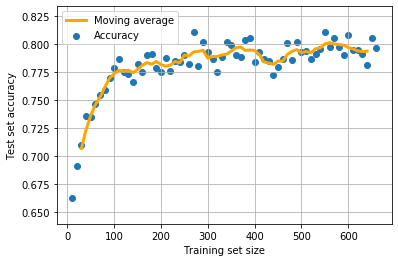

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate moving avergae (of last 5 points) with np.convolve
moving_average = np.convolve(results_accuracy, np.ones((5,))/5, mode='valid')
x_moving_average = results_training_size[2:-2] # Include offset to centre mean

plt.scatter(results_training_size, results_accuracy, 
         label='Accuracy')

plt.plot(x_moving_average, moving_average,
        label='Moving average',
        color='orange',
        linewidth=3)

plt.xlabel('Training set size')
plt.ylabel('Test set accuracy')
plt.legend()
plt.grid(True)
plt.show()

Accuracy appears to increase significantly up to 100 training points, and then appears to start to plateau in this model at 300-400 data points. It looks unlikely that collecting more data would significantly improve the model.